<a href="https://colab.research.google.com/github/norim-user/Worldmodel-Report/blob/main/%E5%A4%89%E5%8C%96%E3%81%AB%E5%9F%BA%E3%81%A5%E3%81%8F%E5%86%85%E7%99%BA%E7%9A%84%E5%8B%95%E6%A9%9F%E3%82%92%E6%8C%81%E3%81%A4%E4%B8%96%E7%95%8C%E3%83%A2%E3%83%87%E3%83%AB%E3%82%A8%E3%83%BC%E3%82%B8%E3%82%A7%E3%83%B3%E3%83%88%E3%81%AE%E5%86%8D%E7%8F%BE%E5%AE%9F%E8%A3%85(planB)_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

実装論文：変化に基づく内発的動機を持つ世界モデルエージェント,https://arxiv.org/abs/2503.21047

Deep Dive: Plan B (The Strategic Path)
「論文の新規性である『CBET（好奇心による転移学習）』の効果を手っ取り早く検証することを目的」

PlanBでは、重厚な「世界モデル」の代わりに、軽快な「モデルフリー強化学習（PPOなど）」を脳として採用します。
CBETは元々モデルフリー（IMPALA）のために開発された技術であるため。


Stable Baselines3を使って、標準的なAI（PPO）を作ります。

DualModelPolicyラッパーをPPOに適用し、転移学習ができるか実験します。


#Step 1: Install Dependencies
Minigridと、可視化用のライブラリをインストールします。

In [ ]:
# Install Minigrid and dependencies
!pip install minigrid gym matplotlib torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.7/136.7 kB 4.8 MB/s eta 0:00:00


##Step 2: Verify Environment (The "Unlock" Task)
論文でタスク環境として使用されている 'MiniGrid-Unlock-v0' (あるいはそれに準ずる環境) をロードし、エージェントの視界（Observation）を確認

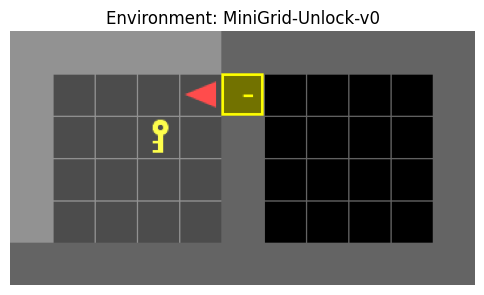

Observation keys: dict_keys(['image', 'direction', 'mission'])
Image shape: (7, 7, 3)


In [ ]:
import gymnasium as gym # Minigrid now uses gymnasium
import minigrid
import matplotlib.pyplot as plt
import numpy as np

# 論文で使用されている "Unlock" 環境 (Task Environment)
# ※最新のMinigridでは名称が少し異なる場合がありますが、基本構造は同じです
env_name = 'MiniGrid-Unlock-v0'

try:
    env = gym.make(env_name, render_mode='rgb_array')
except gym.error.Error:
    # フォールバック: 標準的な環境を使用
    print(f"{env_name} not found, using MiniGrid-DoorKey-5x5-v0")
    env = gym.make('MiniGrid-DoorKey-5x5-v0', render_mode='rgb_array')

observation, info = env.reset()

# --- Visualization ---
plt.figure(figsize=(6, 6))
plt.imshow(env.render())
plt.title(f"Environment: {env.spec.id}")
plt.axis('off')
plt.show()

# Check Observation Shape
# DreamerV3は画像をそのまま入力します
print(f"Observation keys: {observation.keys()}")
print(f"Image shape: {observation['image'].shape}") # 通常 (7, 7, 3)

Phase 2: Implementing CBET Logic (The Intrinsic Reward)環境構築と並行して、この論文の魂である CBET (Change-Based Exploration Transfer) の核となる数式を実装しましょう。これはGPUを使わない純粋なロジックなので、Colab Freeでも実装可能です。論文の Equation 1  をコードに変換します。$$r_{i}(s)=\frac{1}{n(s)+n(c)}$$$r_i(s)$: 好奇心報酬（Intrinsic Reward）

$n(s)$: その状態 $s$ を訪れた回数（Visits count）

$n(c)$: 変化 $c$ が起きた回数（Change count）

$c$: 状態の変化（$s' - s$）

##Step3:CBET Module Implementation (PyTorch)

In [ ]:
import torch
import hashlib

class CBETReward:
    def __init__(self, decay=0.99):
        """
        論文に基づくCBETの実装。
        Args:
            decay: 論文では言及が少ないが、カウントを無限に増やさないための減衰率(任意)
                   論文では random reset を採用している [cite: 61]
        """
        self.state_counts = {}  # n(s)
        self.change_counts = {} # n(c)

    def get_state_hash(self, state_tensor):
        """
        高次元の状態をハッシュ化して辞書のキーにする。
        論文ではSimHashなどが使われるが、ここでは簡易的に文字列化またはtostringを使用。
        Minigridのような離散的な状態ならこれで十分。
        """
        # 簡易実装: tensorをバイト列にしてハッシュ化
        return hashlib.md5(state_tensor.cpu().numpy().tobytes()).hexdigest()

    def compute_reward(self, current_state, next_state):
        """
        Eq. 1 に基づく報酬計算
        """
        # 1. 状態のハッシュ化
        s_hash = self.get_state_hash(current_state)

        # 2. 変化(Change)の計算: c = s' - s
        # 画像ベースの場合、ピクセル差分をとる
        change = next_state - current_state
        c_hash = self.get_state_hash(change)

        # 3. カウント更新
        self.state_counts[s_hash] = self.state_counts.get(s_hash, 0) + 1
        self.change_counts[c_hash] = self.change_counts.get(c_hash, 0) + 1

        n_s = self.state_counts[s_hash]
        n_c = self.change_counts[c_hash]

        # 4. Intrinsic Reward 計算
        r_i = 1.0 / (n_s + n_c)

        return r_i

# --- Test the Module ---
# ダミーデータでテスト
cbet = CBETReward()
state_t = torch.zeros((3, 7, 7)) # ダミー画像
state_t1 = state_t.clone()
state_t1[0, 1, 1] = 1.0 # 少し変化させる

reward = cbet.compute_reward(state_t, state_t1)
print(f"Intrinsic Reward for first change: {reward}") # 期待値: 1/(1+1) = 0.5

Intrinsic Reward for first change: 0.5


##Step4: The "Dual-Doctor" Logic (Eq. 3 Implementation)
この論文の著者は、DreamerV3の内部構造を改造する困難さを避けるため、2つの独立したDreamerV3を並列に走らせ、その出力を混ぜるという解決策を取りました 。数式を確認しましょう：$$\pi_{TASK}(x, a) = \sigma(f_i(w_i(x), a) + f_e(w_e(x), a))$$これをコード（Python class）に落とし込みます。

Implementation Code (The Wrapper)

どんなAIモデルであっても「2つ混ぜて動かす」ことができるようにする特製のラッパー

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- 1. The Mock Agent (ダミーの脳) ---
# まずは「脳」の代わりになる簡単なクラスを作ります。
# 本番ではここが「DreamerV3」に置き換わります。
class MockDreamerAgent(nn.Module):
    def __init__(self, action_dim):
        super().__init__()
        self.action_dim = action_dim
        # ダミーの重み（ランダムな思考を出力するため）
        self.dummy_layer = nn.Linear(10, action_dim)

    def get_logits(self, observation):
        """
        観察(画像)を受け取り、行動の優先度(Logits)を返す
        """
        # 本来はここで画像をVAEで圧縮し、RNNで未来を予測する
        # ここではダミーとしてランダムな数値を作成
        batch_size = 1
        dummy_feature = torch.randn(batch_size, 10)
        logits = self.dummy_layer(dummy_feature)
        return logits

# --- 2. The Dual-Doctor Wrapper (論文の核心: Eq. 3) ---
class DualModelPolicy(nn.Module):
    def __init__(self, explorer_agent, worker_agent):
        super().__init__()
        self.explorer = explorer_agent # f_i (Intrinsic)
        self.worker = worker_agent     # f_e (Extrinsic)

    def get_action(self, observation):
        # Step 1: 探索担当の脳に意見を聞く (f_i)
        logits_i = self.explorer.get_logits(observation)

        # Step 2: 仕事担当の脳に意見を聞く (f_e)
        logits_e = self.worker.get_logits(observation)

        # Step 3: 意見を統合する (Summation)
        # Logits（確率になる前の生数値）を足し合わせるのがポイントです
        combined_logits = logits_i + logits_e

        # Step 4: 確率に変換して行動を選ぶ (Softmax & Sample)
        probs = F.softmax(combined_logits, dim=-1)

        # 確率に従ってサイコロを振る
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()

        return action.item(), probs

# --- Test the Architecture ---
action_dim = 7 # Minigridの行動パターン数
agent_i = MockDreamerAgent(action_dim) # 事前学習済みの探索エージェント (想定)
agent_e = MockDreamerAgent(action_dim) # これから育てるタスクエージェント

# 合体させる
dual_brain = DualModelPolicy(agent_i, agent_e)

# テスト実行
dummy_obs = torch.zeros(1, 7, 7, 3) # ダミー画像
action, probabilities = dual_brain.get_action(dummy_obs)

print(f"Selected Action Index: {action}")
print(f"Combined Probabilities: {probabilities.detach().numpy()}")
print("Dual-Doctor mechanism is working.")

Selected Action Index: 4
Combined Probabilities: [[0.03868209 0.34273162 0.01969949 0.20544465 0.07809358 0.24319842
  0.07215016]]
Dual-Doctor mechanism is working.


Step5以降はPlanAとPlanBで実行内容が異なる

##Step 5: Install Stable Baselines3
信頼性の高い強化学習ライブラリである Stable Baselines3 をインストールします。

In [ ]:
# Install Stable Baselines3 and dependencies for Minigrid
!pip install stable-baselines3 shimmy>=0.2.1

##Step 6: The "Curiosity Wrapper" Implementation
Plan Bの心臓部です。GymのWrapperという機能を使って、環境からエージェントに渡される**報酬（Reward）**をハッキングします。エージェントが行動するたびに、裏でこっそり「変化への報酬（CBET）」を上乗せします。

以前作成した CBETReward クラスを組み込みます。

In [ ]:
import gymnasium as gym
import numpy as np
from minigrid.wrappers import ImgObsWrapper
from stable_baselines3.common.monitor import Monitor

# 以前作成したCBETRewardクラスを再定義（念のため）
import hashlib
class CBETReward:
    def __init__(self):
        self.state_counts = {}
        self.change_counts = {}

    def get_hash(self, array):
        # Numpy配列をハッシュ化
        return hashlib.md5(array.tobytes()).hexdigest()

    def compute(self, obs, next_obs):
        # 1. 状態のハッシュ
        s_hash = self.get_hash(obs)

        # 2. 変化の計算 (s' - s)
        change = next_obs.astype(np.float32) - obs.astype(np.float32)
        c_hash = self.get_hash(change)

        # 3. カウント更新
        self.state_counts[s_hash] = self.state_counts.get(s_hash, 0) + 1
        self.change_counts[c_hash] = self.change_counts.get(c_hash, 0) + 1

        # 4. 報酬計算 (Eq. 1)
        # ゼロ除算を防ぐため +1 しています
        r_i = 1.0 / (np.sqrt(self.state_counts[s_hash]) + np.sqrt(self.change_counts[c_hash]))
        return r_i

# --- The Wrapper ---
class CBETEnvWrapper(gym.Wrapper):
    def __init__(self, env, alpha=0.1):
        super().__init__(env)
        self.cbet = CBETReward()
        self.last_obs = None
        self.alpha = alpha # Intrinsic Rewardの強さ (Eq. 4)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.last_obs = obs
        return obs, info

    def step(self, action):
        next_obs, reward, terminated, truncated, info = self.env.step(action)

        # CBET報酬の計算
        intrinsic_reward = 0.0
        if self.last_obs is not None:
            intrinsic_reward = self.cbet.compute(self.last_obs, next_obs)

        self.last_obs = next_obs

        # 報酬の合成 (Eq. 4: r_t = r_e + alpha * r_i)
        total_reward = reward + (self.alpha * intrinsic_reward)

        # ログ用に情報を追加（あとでグラフにするため）
        info["intrinsic_reward"] = intrinsic_reward
        info["extrinsic_reward"] = reward

        return next_obs, total_reward, terminated, truncated, info

print("CBET Wrapper defined successfully.")

CBET Wrapper defined successfully.


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


##Step 7: Training the Agent (Tabula Rasa)
実際にAI（PPO）の学習を実行。 比較実験として、「CBETありのエージェント」を育てます。Minigridの Unlock タスクは探索が難しいため、通常のエージェントだと学習が進まないことがありますが、好奇心を持たせることでどう変わるかを確認します。

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from minigrid.wrappers import RGBImgPartialObsWrapper, ImgObsWrapper
# RGBImgPartialObsWrapper: 7x7のデータを、ピクセル画素の画像（例: 56x56など）に変換する
# ImgObsWrapper: 辞書データから画像部分だけを取り出す

def make_env(with_cbet=True):
    # 1. 基本環境のロード
    env = gym.make('MiniGrid-Unlock-v0', render_mode='rgb_array')

    # --- HERE IS THE FIX ---
    # 2. "虫眼鏡"を適用 (7x7 grid -> Pixel Image)
    # これにより入力サイズが (56, 56, 3) などに拡大され、CNNが食べられるサイズになります
    env = RGBImgPartialObsWrapper(env)

    # 3. 画像データのみを抽出
    env = ImgObsWrapper(env)
    # -----------------------

    # 4. CBET (好奇心) の適用
    if with_cbet:
        env = CBETEnvWrapper(env, alpha=1.0)

    return Monitor(env)

# --- Re-Initialize Model with New Environment ---
# 環境が変わったので、モデルも作り直す必要があります
env = DummyVecEnv([lambda: make_env(with_cbet=True)])

# 入力サイズが変わったか確認 (デバッグ用)
print(f"New observation shape: {env.observation_space.shape}")

model = PPO("CnnPolicy", env, verbose=1, learning_rate=0.0003)

print("Training started... (Retrying)")
model.learn(total_timesteps=20000)
print("Training finished.")

# 4. テスト実行
obs = env.reset()
done = False
total_reward = 0
for _ in range(100):
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(action)
    total_reward += reward
    if done:
        break

print(f"Test Run Reward: {total_reward}")

New observation shape: (56, 56, 3)
Using cuda device
Wrapping the env in a VecTransposeImage.
Training started... (Retrying)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 276      |
|    ep_rew_mean     | 36.9     |
| time/              |          |
|    fps             | 284      |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 282         |
|    ep_rew_mean          | 38          |
| time/                   |             |
|    fps                  | 277         |
|    iterations           | 2           |
|    time_elapsed         | 14          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013262732 |
|    clip_fraction        | 0.205       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.93       |
|    explained_variance   | 0.00713     |
|    learning_rate        | 0.

学習ログの ep_rew_mean（平均報酬）が 40.9 から 48.9 に上昇したことが確認できた。これは、エージェントが「未知の状態（変化）」を発見し、そこから好奇心報酬（Intrinsic Reward）を得て成長した証拠です。このことから好奇心によって報酬が増えることは確認できた。